<a href="https://colab.research.google.com/github/Auhre/Ecommerce-Fraud-Detection/blob/main/Ecommerce_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ecommerce Fraud Detection with RNN together with GAN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('fraud-ecomm.csv')
data

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,c8604004-2f4c-42ce-a1c4-cd2bebca79bb,f8a534ad-0458-465e-a85b-3ad2cdf391bc,208.48,2024-01-12 23:39:55,PayPal,health & beauty,2,29,North Laurafort,desktop,27.245.104.92,USNV Griffin\nFPO AA 52700,USNV Griffin\nFPO AA 52700,0,149,23
1472948,fff0df19-fd4a-42a5-bc42-64bb7b02edb0,f2ef2239-d9b9-40d0-9993-4b8f305d5a7b,231.57,2024-03-27 04:31:45,credit card,clothing,2,32,Burnsville,tablet,203.54.50.163,"478 John Square Apt. 235\nMillerhaven, GA 68797","478 John Square Apt. 235\nMillerhaven, GA 68797",0,132,4
1472949,9e79012f-e00b-47d1-8700-0c302db20d3e,fa5b9a25-9606-478a-8abe-ef20bbb3980f,101.80,2024-01-31 23:51:42,bank transfer,electronics,4,36,Garciafort,mobile,51.241.30.149,"351 Frazier Radial Apt. 989\nPort Charles, OH ...","182 House Island Suite 198\nEast Scott, FM 84301",0,98,23
1472950,917066b1-4dfb-4472-b3f0-292663c45d21,04524272-e14f-460b-bc70-5316bd28463d,61.80,2024-01-12 16:21:32,bank transfer,electronics,5,34,Lake Josephberg,desktop,210.67.203.4,"27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...","27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...",0,191,16


In [ ]:
class DataPreprocessor():
  def __init__(self, data):
    self.data = data

  def reorder(self, data):
    cols = list(data.columns)
    cols.remove(self.target_col)
    cols.append(self.target_col)
    reordered_data = data[cols]
    return reordered_data

  def clean(self, droplist, target_col):
    self.data.drop(droplist, axis=1, inplace=True)
    self.target_col = target_col
    self.data.dropna(inplace=True)
    self.cleaned_data = self.reorder(self.data)
    return self.cleaned_data

  def sanity_check_clean(self):
    print('-------------------------------')
    print('Target Column Value Check:')
    print('-------------------------------')
    print(self.cleaned_data[self.target_col].value_counts())
    print('-------------------------------')
    print('Null Column Value Check:')
    print('-------------------------------')
    print(self.cleaned_data.isnull().sum())

  def fit_transform(self, data):
    data = self.reorder(data)
    categorical_features = data.select_dtypes(include=['object', 'boolean']).columns
    numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_data = data[categorical_features]
    numerical_data = data[numerical_features]
    self.num_features_shape = numerical_data.shape[1]
    self.all_columns_list = list(categorical_data.columns) + list(numerical_data.columns)
    preprocessor = ColumnTransformer(
        [
            ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('minmax', MinMaxScaler(), numerical_features)
        ],
        remainder='passthrough'
    )
    self.pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])
    self.pipeline.fit(data)
    transformed_data = self.pipeline.transform(data)
    return transformed_data

  def sanity_check_transform(self):
    print('-------------------------------')
    print('Order of Column Check:')
    print('-------------------------------')
    print(self.all_columns_list)

  def inverse_transform(self, data):
    column_transformer = self.pipeline.named_steps['preprocessor']
    num_transformer = column_transformer.named_transformers_['minmax']
    cat_transformer = column_transformer.named_transformers_['onehot']
    generated_num = num_transformer.inverse_transform(data[:, -self.num_features_shape:])
    generated_num[:, :-1] = np.round(generated_num[:, :-1])

    generated_num[generated_num[:, :] < 0] = 0

    generated_cat = cat_transformer.inverse_transform(data[:, 0: data.shape[1] - self.num_features_shape])
    combined_data = np.concatenate((generated_cat, generated_num), axis=1)

    df = pd.DataFrame(combined_data, columns=self.all_columns_list[:len(combined_data[0])])
    return combined_data, df

  def transform(self, data):
    transformed_data = self.pipeline.transform(data)
    return transformed_data

In [ ]:
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'])
data['Day of Week'] = data['Transaction Date'].dt.dayofweek
data['Day of Week'] = data['Day of Week'].astype(int)
data['Billing Shipping Address Match'] = data['Billing Address'] == data['Shipping Address']
data['Billing Shipping Address Match'] = data['Billing Shipping Address Match'].astype(int)

In [ ]:
dp = DataPreprocessor(data)

In [ ]:
cleaned_data = dp.clean(
    droplist=['Transaction ID', 'Customer ID', 'IP Address', 'Billing Address', 'Shipping Address', 'Customer Location', 'Transaction Date'],
    target_col='Is Fraudulent')
cleaned_data.head(15)

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Account Age Days,Transaction Hour,Day of Week,Billing Shipping Address Match,Is Fraudulent
0,58.09,bank transfer,electronics,1,17,tablet,30,5,1,1,0
1,389.96,debit card,electronics,2,40,desktop,72,8,6,1,0
2,134.19,PayPal,home & garden,2,22,tablet,63,3,0,1,0
3,226.17,bank transfer,clothing,5,31,desktop,124,20,5,1,0
4,121.53,bank transfer,clothing,2,51,tablet,158,5,0,1,0
5,166.41,bank transfer,toys & games,2,34,tablet,38,10,1,0,0
6,92.88,PayPal,toys & games,2,14,tablet,119,19,6,1,0
7,318.14,credit card,health & beauty,4,42,desktop,251,13,1,1,0
8,47.92,bank transfer,home & garden,4,38,desktop,190,19,6,1,0
9,121.78,bank transfer,health & beauty,4,39,mobile,343,21,1,1,0


In [ ]:
dp.sanity_check_clean()

-------------------------------
Target Column Value Check:
-------------------------------
Is Fraudulent
0    1399114
1      73838
Name: count, dtype: int64
-------------------------------
Null Column Value Check:
-------------------------------
Transaction Amount                0
Payment Method                    0
Product Category                  0
Quantity                          0
Customer Age                      0
Device Used                       0
Account Age Days                  0
Transaction Hour                  0
Day of Week                       0
Billing Shipping Address Match    0
Is Fraudulent                     0
dtype: int64


In [ ]:
transformed_data = dp.fit_transform(cleaned_data)
transformed_data

array([[0.        , 1.        , 0.        , ..., 0.16666667, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.33333333, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.66666667, 1.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
dp.sanity_check_transform()

-------------------------------
Order of Column Check:
-------------------------------
['Payment Method', 'Product Category', 'Device Used', 'Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour', 'Day of Week', 'Billing Shipping Address Match', 'Is Fraudulent']


# GAN

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, output_dim)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.tanh = nn.Tanh()
  def forward(self, z):
    x = self.leaky_relu(self.fc1(z))
    x = self.leaky_relu(self.fc2(x))
    x = self.tanh(self.fc3(x))
    return x

class Discriminator(nn.Module):
  def __init__(self, input_dim):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(input_dim, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 1)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.sigmoid = nn.Sigmoid()
  def forward(self, z):
    x = self.leaky_relu(self.fc1(z))
    x = self.leaky_relu(self.fc2(x))
    x = self.sigmoid(self.fc3(x))
    return x

In [ ]:
class GAN():
  def __init__(self, input_dim, output_dim, latent_dim):
    self.generator = Generator(input_dim, output_dim)
    self.discriminator = Discriminator(output_dim)
    self.latent_dim = latent_dim

  def train(self, data, num_epochs=10, batch_size=64, lr=0.0002):
    criterion = nn.BCELoss()
    d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr)
    real_dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(num_epochs):
      for real_data in real_dataloader:
        real_data = real_data[0].clone().detach()
        z = torch.randn(batch_size, self.latent_dim)
        fake_data = self.generator(z)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        d_optimizer.zero_grad()
        real_output = self.discriminator(real_data)
        d_real_loss = criterion(real_output, real_labels)
        fake_output = self.discriminator(fake_data.detach())
        d_fake_loss = criterion(fake_output, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, self.latent_dim)
        fake_data = self.generator(z)
        fake_output = self.discriminator(fake_data)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        g_optimizer.step()
      print(f'Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item()}, G_loss: {g_loss.item()}')

  def generate(self, num_samples=100):
    random_noise = torch.randn(num_samples, self.latent_dim)
    self.generator.eval()
    with torch.no_grad():
      synthetic_data = self.generator(random_noise)
    return synthetic_data

In [ ]:
gan = GAN(input_dim=100, output_dim=transformed_data.shape[1], latent_dim=100)
gan.train(data=transformed_data, num_epochs=5, batch_size=64, lr=0.0001)

Epoch [1/5], D_loss: 0.5455454587936401, G_loss: 2.5885772705078125
Epoch [2/5], D_loss: 0.348034143447876, G_loss: 2.08673357963562
Epoch [3/5], D_loss: 0.31907153129577637, G_loss: 3.0394785404205322
Epoch [4/5], D_loss: 0.14406345784664154, G_loss: 3.9490444660186768
Epoch [5/5], D_loss: 0.11774694174528122, G_loss: 6.963094711303711


In [ ]:
constructed_data = gan.generate(num_samples=3000000)
constructed_data

tensor([[-4.3771e-03,  1.0000e+00, -5.6543e-03,  ...,  9.6427e-01,
          1.0000e+00, -2.2327e-02],
        [ 8.3851e-04,  5.9600e-03,  1.1775e-03,  ...,  6.2712e-01,
          1.0000e+00, -5.1595e-04],
        [-1.0377e-02,  9.9988e-01, -7.4299e-03,  ...,  4.9909e-01,
          9.9997e-01, -3.3274e-02],
        ...,
        [-5.4581e-03,  9.9808e-01, -3.6589e-03,  ...,  2.6604e-01,
          9.9819e-01, -1.8845e-02],
        [ 1.8735e-03,  4.7807e-03,  3.4699e-04,  ...,  6.3043e-01,
          9.9978e-01,  8.0616e-04],
        [ 1.7258e-03, -7.1820e-03, -7.2898e-04,  ...,  5.6132e-02,
          9.9960e-01, -2.4537e-03]])

In [ ]:
class GANBinaryClassBalancer():
  def __init__(self, original_data, processed_data, synthetic_data, target_col):
    self.synthetic_data = synthetic_data
    self.processed_data = processed_data
    self.real_false_counts = original_data[target_col].value_counts()[0]
    self.real_true_counts = original_data[target_col].value_counts()[1]
    self.synthetic_data[:, -1] = torch.where(self.synthetic_data[:, -1] <= 0, torch.tensor(0), torch.tensor(1))

  def balance_class(self, class_balancer_num):
    self.class_balancer_num = class_balancer_num
    self.synthetic_true = self.synthetic_data[self.synthetic_data[:, -1] == 1]
    self.synthetic_true = self.synthetic_true[:self.class_balancer_num - self.real_true_counts, :]
    self.synthetic_false = self.synthetic_data[self.synthetic_data[:, -1] == 0]
    self.synthetic_false = self.synthetic_false[:self.class_balancer_num - self.real_false_counts, :]
    self.balancer_synthetic_data = torch.cat((self.synthetic_true, self.synthetic_false), dim=0)
    extended_data = np.concatenate((self.processed_data, self.balancer_synthetic_data), axis=0)
    return extended_data

  def sanity_check(self):
    print('Completed balancing both classes with {0} entries'.format(self.class_balancer_num))
    print('Aditional synthetic true: {0}'.format(self.synthetic_true.shape[0]))
    print('Aditional synthetic false: {0}'.format(self.synthetic_false.shape[0]))
    print('Unique value check for synthetic true: {0}'.format(self.synthetic_true[:, -1].unique()))
    print('Unique value check for synthetic false: {0}'.format(self.synthetic_false[:, -1].unique()))

In [ ]:
sb = GANBinaryClassBalancer(cleaned_data, transformed_data, constructed_data, 'Is Fraudulent')
transformed_balanced_fraud_dataset = sb.balance_class(1500000)
sb.sanity_check()

Completed balancing both classes with 1500000 entries
Aditional synthetic true: 1426162
Aditional synthetic false: 100886
Unique value check for synthetic true: tensor([1.])
Unique value check for synthetic false: tensor([0.])


In [ ]:
transformed_balanced_fraud_dataset.shape

(3000000, 20)

In [ ]:
extended_fraud_data, extended_fraud_df = dp.inverse_transform(transformed_balanced_fraud_dataset)
extended_fraud_df['Is Fraudulent'].value_counts()

,count
Is Fraudulent,
0.0,1500000
1.0,1500000


In [ ]:
extended_fraud_df

,Payment Method,Product Category,Device Used,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of Week,Billing Shipping Address Match,Is Fraudulent
0,bank transfer,electronics,tablet,58.0,1.0,17.0,30.0,5.0,1.0,1.0,0.0
1,debit card,electronics,desktop,390.0,2.0,40.0,72.0,8.0,6.0,1.0,0.0
2,PayPal,home & garden,tablet,134.0,2.0,22.0,63.0,3.0,0.0,1.0,0.0
3,bank transfer,clothing,desktop,226.0,5.0,31.0,124.0,20.0,5.0,1.0,0.0
4,bank transfer,clothing,tablet,122.0,2.0,51.0,158.0,5.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2999995,debit card,electronics,mobile,270.0,4.0,43.0,266.0,1.0,2.0,1.0,0.0
2999996,debit card,electronics,mobile,850.0,5.0,52.0,359.0,9.0,5.0,1.0,0.0
2999997,debit card,electronics,tablet,700.0,2.0,47.0,309.0,6.0,6.0,1.0,0.0
2999998,debit card,clothing,tablet,561.0,2.0,43.0,294.0,5.0,2.0,1.0,0.0


In [ ]:
def plot_feature_distribution(df, col):
  plt.figure(figsize=(10, 6))
  sns.histplot(df[col], bins=30, kde=True)
  plt.title('Distribution of {0} in the Extended Fraud Dataset by GAN'.format(col))
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.show()

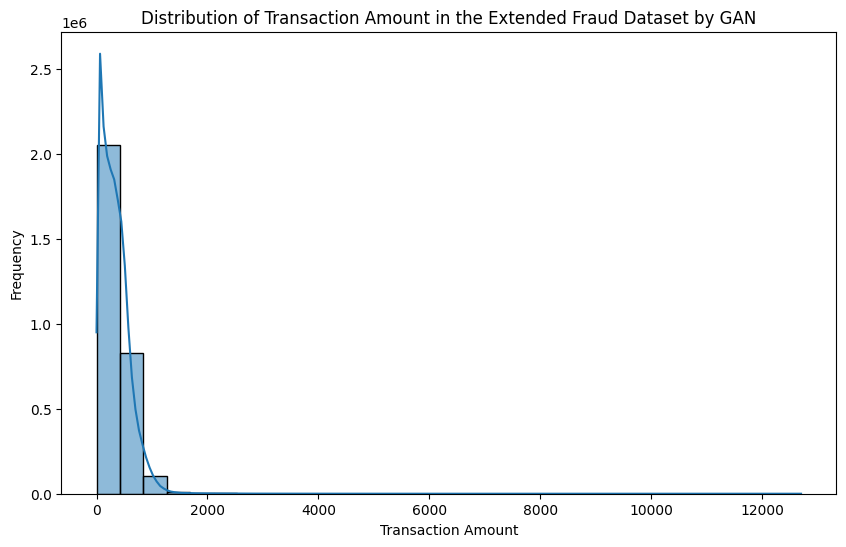

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Transaction Amount')

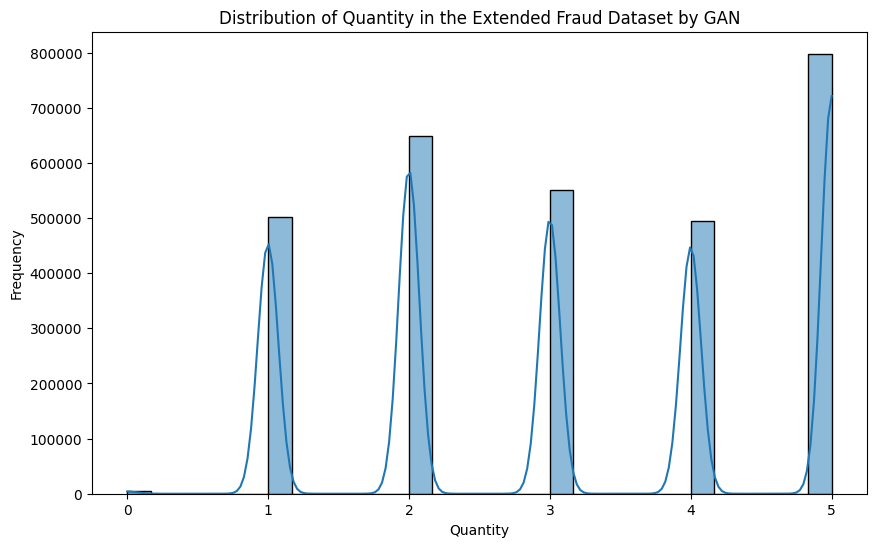

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Quantity')

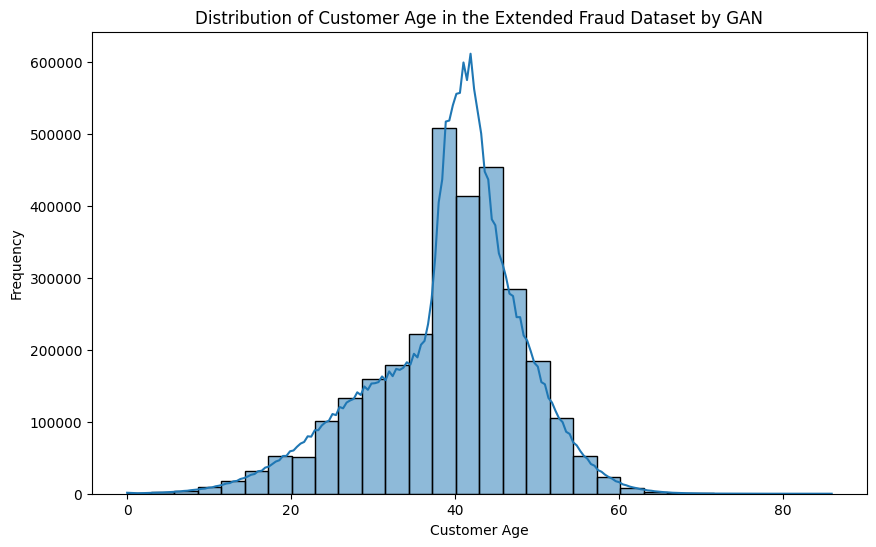

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Customer Age')

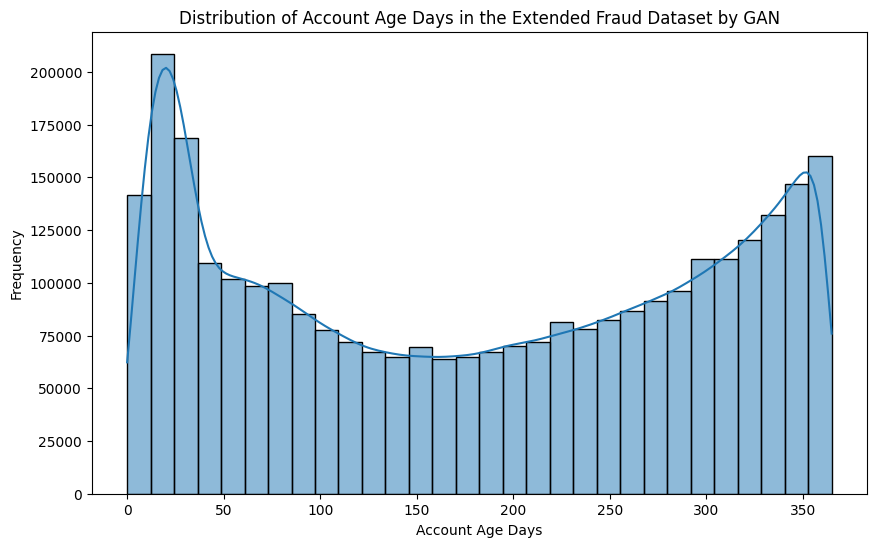

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Account Age Days')

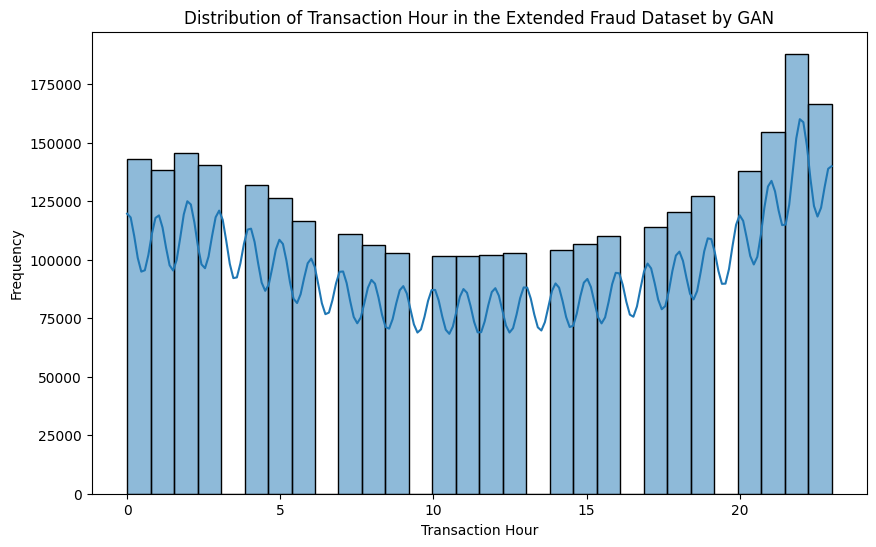

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Transaction Hour')

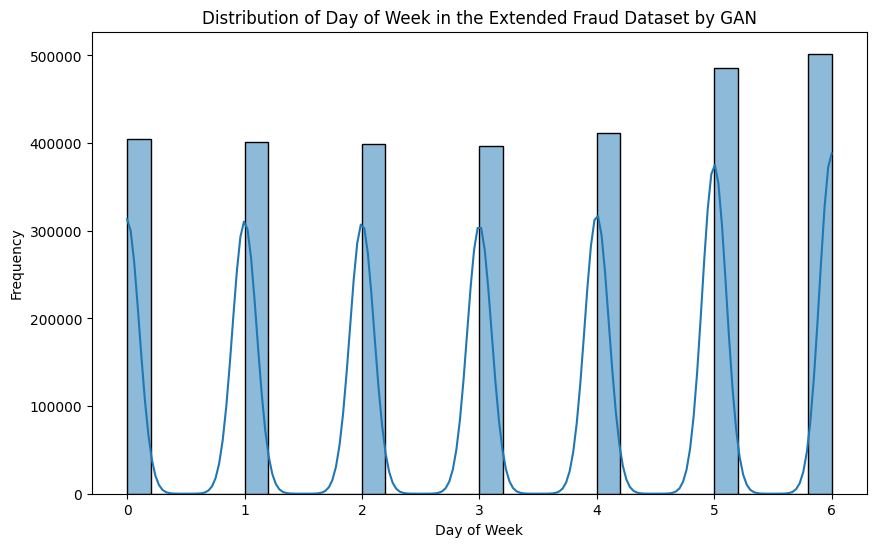

In [ ]:
plot_feature_distribution(extended_fraud_df, 'Day of Week')

### LSTM for fraud detection


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
X = transformed_balanced_fraud_dataset[:, :-1]
y = transformed_balanced_fraud_dataset[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stop])

Epoch 1/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 991s 33ms/step - accuracy: 0.8670 - loss: 0.3306 - val_accuracy: 0.9402 - val_loss: 0.1860
Epoch 2/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 993s 31ms/step - accuracy: 0.9428 - loss: 0.1833 - val_accuracy: 0.9504 - val_loss: 0.1576
Epoch 3/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 991s 32ms/step - accuracy: 0.9500 - loss: 0.1607 - val_accuracy: 0.9532 - val_loss: 0.1494
Epoch 4/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 962s 32ms/step - accuracy: 0.9548 - loss: 0.1465 - val_accuracy: 0.9596 - val_loss: 0.1314
Epoch 5/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 968s 32ms/step - accuracy: 0.9584 - loss: 0.1360 - val_accuracy: 0.9607 - val_loss: 0.1274
Epoch 6/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 976s 31ms/step - accuracy: 0.9605 - loss: 0.1293 - val_accuracy: 0.9614 - val_loss: 0.1237
Epoch 7/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 948s 32ms/step - accuracy: 0.9620 - loss: 0.1252 - val_accuracy: 0.9620 - val_loss: 0.1223
Epoch 8/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 1026s 33ms/

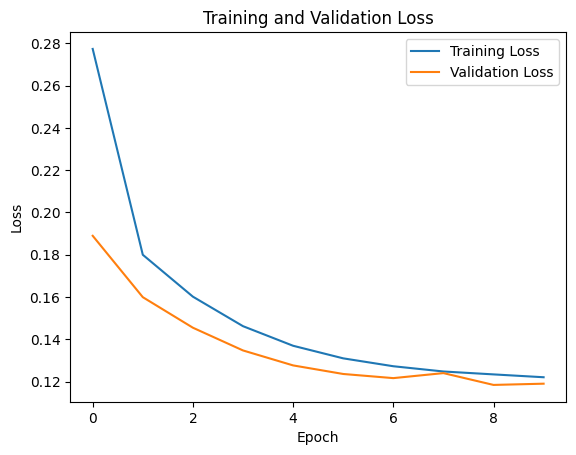

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
extended_fraud_df.columns

Index(['Payment Method', 'Product Category', 'Device Used',
       'Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days',
       'Transaction Hour', 'Day of Week', 'Billing Shipping Address Match',
       'Is Fraudulent'],
      dtype='object')

In [ ]:
transaction_entry = {
    'Payment Method': 'bank transfer',
    'Product Category': 'electronics',
    'Device Used': 'tablet',
    'Billing Shipping Address Match': 0,
    'Transaction Amount': 1214,
    'Quantity': 3,
    'Customer Age': 19,
    'Account Age Days': 4,
    'Transaction Hour': 22,
    'Day of Week': 4,
    'Is Fraudulent': None
}

transaction_entry_df = pd.DataFrame([transaction_entry])
transaction_entry_df

,Payment Method,Product Category,Device Used,Billing Shipping Address Match,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of Week,Is Fraudulent
0,bank transfer,electronics,tablet,0,1214,3,19,4,22,4,None


In [ ]:
e = dp.transform(transaction_entry_df)
e = e[:, :-1]

In [ ]:
e

array([[0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.09486477, 0.5       , 0.34313725,
        0.00824176, 0.95652174, 0.66666667, 0.        ]])

In [ ]:
prediction = model.predict(e)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([[0.55921537]], dtype=float32)

In [ ]:
fraud_result = 1 if prediction > 0.5 else 0
fraud_result

1